In [1]:
import tcellmatch.api as tm
import torch as tc
import torch.nn as nn
from math import exp, log
import matplotlib.pyplot as plt

In [2]:
saved_model_path = '../tutorial_data/saved_model-8-2--18:56'
ffn = tm.models.EstimatorFfn()
ffn.load_model_full(fn=saved_model_path, load_train_data=False)

device = 'cuda' if tc.cuda.is_available() else 'cpu'
# device='cpu'
ffn.model = ffn.model.to(device) 
for param in ffn.model.parameters():
    param = param.to(device) 

In [3]:
ffn.predict()

In [4]:
N_SAMPLES = 10
import numpy as np

In [5]:
length_param = np.median(np.abs(ffn.y_test[:, None] - ffn.y_test[None, :])) + 1e-6

In [6]:
# calculate reference vars for second term, (ε_i | ε_j)_k
def k(y, y_):
    # take sigma squared to be y
    return tc.exp(-1/(2 * length_param) * (tc.log(y + 1) - tc.log(y_ + 1)) ** 2)
def c(lmd1, lmd2, tau):
    # a and b are lambda values
    delta_E = lmd1 - lmd2
    delta_sd = tc.sqrt(lmd1) - tc.sqrt(lmd2)
    return tc.exp(-1/(2 * length_param ** 2) * (delta_E ** 2 + delta_sd ** 2))

In [7]:
def mmd_pois(y_hat_mtx, y_mtx):
    # 1) prepare 
    y_hat_mtx, y_mtx = tc.Tensor(y_hat_mtx).to(device), tc.Tensor(y_mtx).to(device)
    n, n_antigens = y_hat_mtx.shape
    n = min(N_SAMPLES, n)
    samples_idx = tc.randperm(y_hat_mtx.size(0))[:N_SAMPLES]
    y_hat_mtx, y_mtx = y_hat_mtx[samples_idx], y_mtx[samples_idx]
    # acct for log lmd
    y_hat_mtx = tc.exp(y_hat_mtx)
    

    out = tc.zeros(n_antigens, device=device)

    # 3) Look at each antigen
    for col in range(n_antigens):
        # 1) compute matrix for each value of C term
        y, y_hat = y_mtx[:, col], y_hat_mtx[:, col]
        C = c(y_hat[:, None], y_hat[None, :], 5) # shape n x n
        # 2) Compute matrix for the expected value over BOTH inputs to the kernel, E k(y, y')
        # create matrix of samples:
        # samples_one_{ij} = jth sample from Pois(y_hat_i)
        s = 1000
        samples_one = tc.poisson(y_hat[:, None].expand(n, s)) # shape n x s
        samples_two = tc.poisson(y_hat[:, None].expand(n, s))

        # Reshape for broadcasting
        samples_a = samples_one[:, None, :, None] 
        samples_b = samples_two[None, :, None, :]
        # Compute k for each combination of draws
        # - call this matrix B for EV over BOTH inputs
        B = k(samples_a, samples_b) # shape n x n x s x s
        
        # 3) Compute E k(y, y_i)
        # reshape y for broadcasting
        y_reshaped = y[:, None, None]
        samples_three = tc.poisson(y_hat[:, None].expand(n, s)).unsqueeze(0)
        # # compute k for each combination
        M = k(y_reshaped, samples_three) # shape n x n x s
        # 4) Compute the eNd term, N_{ij} = k(y_i, y_j)
        N = k(y_hat[:, None], y_hat[None, :]) # shape n x n
        
        # 5) Put it all together
        # we want all mcs to be of shape n x n
        # take average over samples        
        B = B.mean(dim=(-2, -1))
        M = M.mean(dim=-1)
        # print(tc.nonzero(tc.isnan(C), as_tuple=False))
        # print(tc.nonzero(tc.isnan(B), as_tuple=False))
        # print(tc.nonzero(tc.isnan(M), as_tuple=False))
        # print(tc.nonzero(tc.isnan(N), as_tuple=False))
        K = B - 2 * M + N
        ans = (C * K).mean()
        out[col] = ans
        tc.cuda.empty_cache()
        del B
        del M
        del N
        del C
        del K
    return out

In [8]:
out = mmd_pois(ffn.predictions, ffn.y_test)

(array([13., 12.,  2.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.,  0.,  1.,  2.,  6.,  2.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.]),
 array([-0.00019466,  0.00086495,  0.00192456,  0.00298417,  0.00404378,
         0.00510339,  0.006163  ,  0.00722261,  0.00828222,  0.00934183,
         0.01040144,  0.01146105,  0.01252066,  0.01358027,  0.01463988,
         0.01569949,  0.0167591 ,  0.01781871,  0.01887832,  0.01993793,
         0.02099754,  0.02205716,  0.02311677,  0.02417638,  0.02523599,
         0.0262956 ,  0.02735521,  0.02841482,  0.02947443,  0.030534

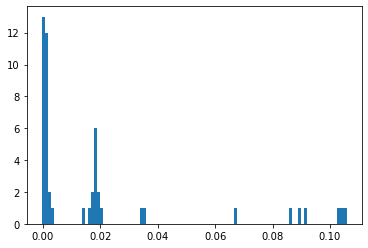

In [9]:
plt.hist(out.cpu(), bins=100)